In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import torchvision
from torchvision import transforms

from utils import *
from learner import *

In [2]:
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def lin(ic, oc, act=nn.ReLU):
    layers = nn.Sequential(nn.Linear(ic, oc))
    if act: layers.append(act())
    return layers

In [4]:
class VAE(nn.Module):
    def __init__(self, ic, hc, lc):
        super().__init__()
        self.encoder = nn.Sequential(lin(ic, hc), lin(hc, hc))
        self.mu, self.lv = lin(hc, lc, act=None), lin(hc, lc, act=None)
        self.decoder = nn.Sequential(lin(lc, hc), lin(hc,hc), lin(hc, ic, act=None), nn.Sigmoid())
    
    def forward(self, x):
        x = self.encoder(x)
        mu, lv = self.mu(x), self.lv(x)
        ep = torch.randn_like(lv)
        z = mu + ((0.5*lv).exp() * ep)
        return self.decoder(z), mu, lv


In [5]:
def loss_fn(X_new, X, mu, lv):
    return F.binary_cross_entropy(X_new, X, reduction="sum") + (-0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp()))

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstructions(model, data, num_samples=10):
    with torch.inference_mode():
        recon_batch, _, _ = model(data.reshape(-1, 784))
        recon_batch = recon_batch.cpu()

    # Plot original images
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(data[i].cpu().view(28, 28).numpy(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

    # Plot reconstructed images
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(recon_batch[i].view(28, 28).numpy(), cmap='gray')
        plt.title('New')
        plt.axis('off')

    plt.show()


In [8]:
ic, hc, lc = 784, 400, 20
lr = 1e-3
vae = VAE(ic, hc, lc)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [9]:
def train(model, epochs):
    model.to(device)
    # schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))

    for epoch in trange(epochs):
        model.train()
        train_loss = 0
        for X, _ in train_dataloader:
            X = X.to(device).view(-1, 784)
            X_new, mu, lv = model(X)
            loss = loss_fn(X_new, X, mu, lv)
            train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch}\tLoss: {train_loss / len(train_dataloader.dataset)}")
        # schedular.step()

In [10]:
data, _ = next(iter(test_dataloader))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	Loss: 159.81996154785156
Epoch: 1	Loss: 122.69841766357422
Epoch: 2	Loss: 114.31310272216797
Epoch: 3	Loss: 110.0690689086914
Epoch: 4	Loss: 107.6080322265625
Epoch: 5	Loss: 106.05316925048828
Epoch: 6	Loss: 104.96757507324219
Epoch: 7	Loss: 104.05165100097656
Epoch: 8	Loss: 103.34119415283203
Epoch: 9	Loss: 102.78547668457031


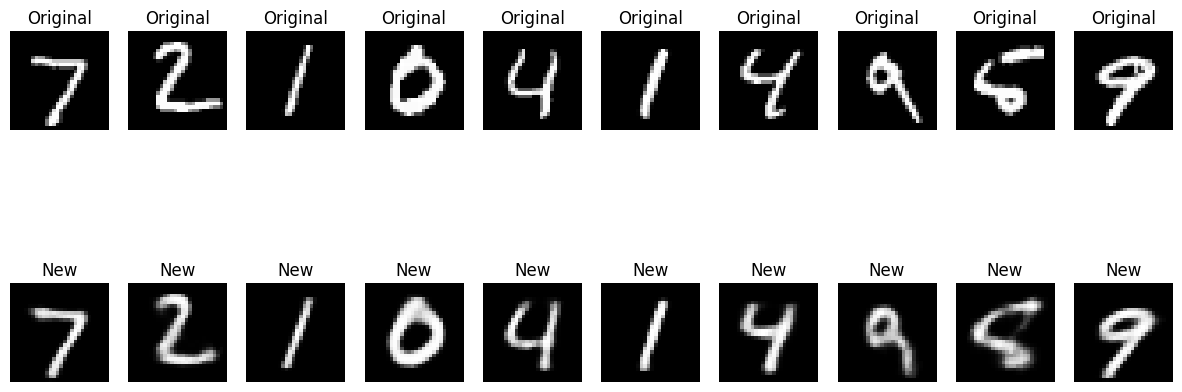

In [11]:
train(vae, 10)
plot_reconstructions(vae, data.to(device))